In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from statsmodels.graphics import tsaplots
import warnings

Restructure the data frame to a usable format 

In [19]:
#get .gov data from the csv
excel_file = 'Gov_data/Consolidated_data.xlsx'
customer_trans_df = pd.read_excel(excel_file, 'Customer_transfers')
inflation_df = pd.read_excel(excel_file, 'Inflation')
fuel_prices_df = pd.read_excel(excel_file, 'Domestic_food_prices')
weekly_earnings_df = pd.read_excel(excel_file, 'Weekly_earnings')
intrest_rate_df = pd.read_excel(excel_file, 'Interest_rate')

combined_df = pd.DataFrame([])

#Include year and month 
for i in [customer_trans_df,inflation_df,fuel_prices_df,weekly_earnings_df,intrest_rate_df]:
    i['month'] = i['date'].dt.month
    i['year'] = i['date'].dt.year
    i.drop('date' ,axis = 1, inplace = True)

    #used for the intrest rate hikes and any future ones were there may be multiple changes in a month 
    i = i.groupby(['month','year']).max().reset_index()
    
    #works if the dataframe is empty 
    if len(combined_df) == 0:
        combined_df = i
    else:
        combined_df = combined_df.merge(i,on= ['month','year'],how = 'left')

#ffill to bring over correct intrest rate and bfill to take into account the first alue that isnt filled 
combined_df = combined_df.sort_values(['year','month']).fillna(method= 'ffill').fillna(method= 'bfill').drop('Gas Transfers',axis = 1).reset_index(drop = True)   

Explore the data

In [13]:
#will concentrate on electricity transfers 
combined_df.head()

,month,year,Electricity Transfers,inflation_index,Solid fuels,Gas,Electrcity,Liquid fuels,Pay(£),Rate
0,1,2003,326000,75.9,53.461975,44.591029,54.673496,41.864268,345.0,3.75
1,2,2003,337000,76.1,53.461975,44.591029,54.673496,49.223222,343.0,3.75
2,3,2003,368000,76.4,53.575482,44.591029,54.673496,50.695012,348.0,3.75
3,4,2003,351000,76.8,53.234960,44.722955,54.673496,37.939493,349.0,3.75
4,5,2003,327000,76.8,52.667423,44.986807,54.801536,35.650041,349.0,3.75


<AxesSubplot: >

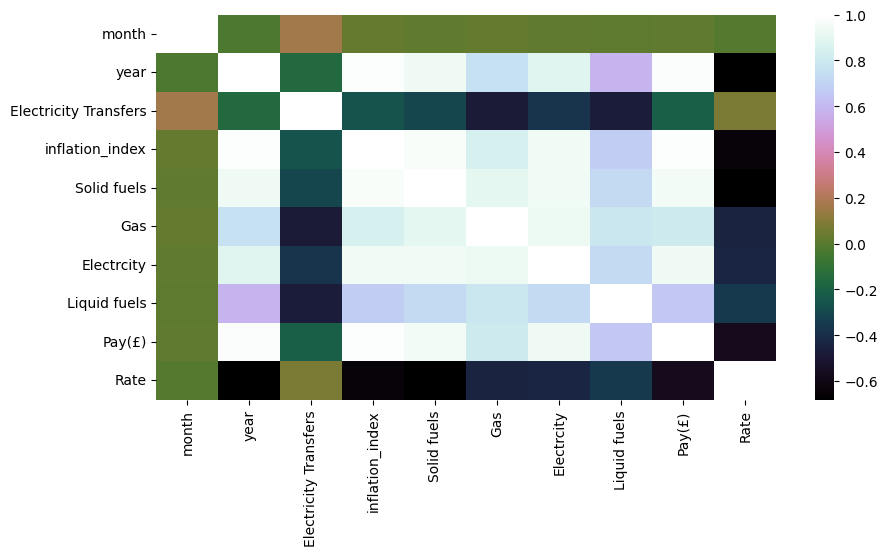

In [14]:
#find the strongest correlating factor to see if any can be reduced down 
plt.figure(figsize = (10,5))
sns.heatmap(combined_df.corr(),cmap="cubehelix")
#Strangely there is a negative correlation between transfers and prices
#maybe when prices are high people have other things on their mind over moving 

In [25]:
#Strangely there is a negative correlation between transfers and prices, maybe when prices are high people have other things on their mind over moving 
combined_df.columns

Index(['month', 'year', 'Electricity Transfers', 'inflation_index',
       'Solid fuels', 'Gas', 'Electrcity', 'Liquid fuels', 'Pay(£)', 'Rate',
       'corr Electricity Transfers 1 days', 'corr inflation_index 173 days',
       'corr Solid fuels 172 days', 'corr Gas 127 days',
       'corr Electrcity 174 days', 'corr Liquid fuels 117 days',
       'corr Pay(£) 173 days', 'corr Rate 184 days'],
      dtype='object')

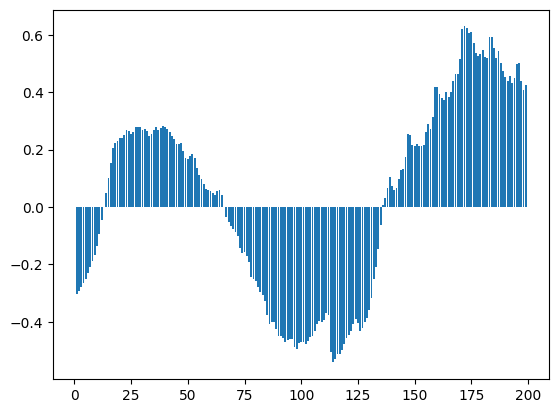

In [31]:
#introduce the change ratio to see if there is any difference 
metric = 'Solid fuels'
# done at a month level
max_periods = 200

corr_df = pd.DataFrame([],columns = ['Lag','corr'])

for i in range(1,max_periods):
    lag_data = combined_df[metric].shift(-i)[:-i]
    sales_data = combined_df['Electricity Transfers'][:-i]

    corr_df_append = pd.DataFrame([[i,np.corrcoef(lag_data,sales_data)[0][1]]],columns = ['Lag','corr'])

    corr_df = pd.concat([corr_df,corr_df_append])

plt.bar(x= corr_df['Lag'],height = corr_df['corr'])

#used just for this run as runtime warning is not needed 
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [ ]:
#Strong positive correlations from the last year showing around a 6 month lag with the change 
#A cyclical pattern over the years most likely bought on ebs and flows of the economy and people getting deals when switching after contracts
#no enough data however to extrapolate back more than a year

In [20]:
#correlation % change and transfers

#introduce the change ratio to see if there is any difference 
# done at a month level
max_periods = 200

columns = combined_df.drop(['month','year'], axis = 1).columns

corr_df_fin = pd.DataFrame([])

for metric in columns:

    corr_df = pd.DataFrame([])

    for i in range(1,max_periods):
        lag_data = combined_df[metric].shift(-i)[:-i]
        sales_data = combined_df['Electricity Transfers'][:-i]

        corr_df_append = pd.DataFrame([[i,np.corrcoef(lag_data,sales_data)[0][1]]],columns = ['days_change','corr ' + metric])

        corr_df = pd.concat([corr_df,corr_df_append])

    if len(corr_df_fin) == 0: 
        corr_df_fin = corr_df
        print(corr_df_fin.columns)
    else:
        corr_df_fin['corr ' + metric] = corr_df['corr ' + metric]

#used just for this run as runtime warning is not needed 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

Index(['days_change', 'corr Electricity Transfers'], dtype='object')


In [21]:
#ddefine the number of periods for each and add to the original data frame 
#do it within 120 
for i in corr_df_fin.drop('days_change',axis = 1).columns:

    opt_days = corr_df_fin[abs(corr_df_fin[i]) == abs(corr_df_fin[i][0:200]).max()]['days_change'][0]

    perc_change_data = (combined_df[metric][:-opt_days] - combined_df[metric].shift(-opt_days)[:-opt_days])/combined_df[metric].shift(-opt_days)[:-opt_days]

    combined_df[i + ' ' + str(opt_days) + ' days'] = perc_change_data

In [23]:
len(combined_df)

243

In [22]:
#Negative correlation between transfers in the most recent period 
#all metrics have a frequency of correlation of around 2 years compared with transers showing a lagging afffect each time 
#Electricity transfers also who an out of phase correlation with itself compared to the other metrics 
#good to introduce a time series element in predicting the change in customers

243

In [14]:
corr_df_fin[abs(corr_df_fin['corr Rate']) == abs(corr_df_fin['corr Rate'][0:120]).max()]['days_change'][0]

97

In [6]:
combined_df

,month,year,Electricity Transfers,inflation_index,Solid fuels,Gas,Electrcity,Liquid fuels,Pay(£),Rate,corr Electricity Transfers 44 days,corr inflation_index 54 days,corr Solid fuels 39 days,corr Gas 66 days,corr Electrcity 43 days,corr Liquid fuels 48 days,corr Pay(£) 104 days,corr Rate 97 days
0,1,2003,326000,75.9,53.461975,44.591029,54.673496,41.864268,345.0,3.75,-0.210526,-0.347826,-0.166667,-0.250000,-0.210526,-0.285714,6.5,6.5
1,2,2003,337000,76.1,53.461975,44.591029,54.673496,49.223222,343.0,3.75,-0.210526,-0.347826,-0.166667,-0.250000,-0.210526,-0.285714,6.5,6.5
2,3,2003,368000,76.4,53.575482,44.591029,54.673496,50.695012,348.0,3.75,-0.250000,-0.347826,-0.166667,-0.250000,-0.210526,-0.285714,6.5,6.5
3,4,2003,351000,76.8,53.234960,44.722955,54.673496,37.939493,349.0,3.75,-0.250000,-0.347826,-0.166667,-0.166667,-0.250000,-0.285714,6.5,6.5
4,5,2003,327000,76.8,52.667423,44.986807,54.801536,35.650041,349.0,3.75,-0.285714,-0.347826,-0.210526,0.250000,-0.250000,-0.318182,6.5,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,11,2022,79000,124.8,180.703746,300.000000,304.865557,195.829926,628.0,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,12,2022,79000,125.3,180.249716,300.000000,304.865557,178.250204,632.0,3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,1,2023,87000,124.8,182.633371,301.055409,308.450704,176.533115,634.0,3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,2,2023,121000,126.0,184.222474,301.055409,308.450704,168.274734,638.0,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
plt.bar(x= corr_df['days_change'],height = corr_df['corr'])

In [123]:
#we see a lagged percentage change from almost all metrics and they have a similar period so can be collapsed with PCA
#Liquid fuels are out of phase compared to other groups
#Intrest rate does not seem to follow fourier analysis so will be discluded 

In [121]:
#add in the percent change to the data frame for each value 


for i in combined_df.drop(['month','year'], axis = 1).columns:
    for j in range(0,len(combined_df)):
        perc_change_data = (combined_df[metric] - combined_df[metric].shift(-j)[:-i])/combined_df[metric].shift(-i)[:-i]

,month,year,Electricity Transfers,inflation_index,Solid fuels,Gas,Electrcity,Liquid fuels,Pay(£),Rate
0,1,2003,326000,75.9,53.461975,44.591029,54.673496,41.864268,345.0,3.75
1,2,2003,337000,76.1,53.461975,44.591029,54.673496,49.223222,343.0,3.75
2,3,2003,368000,76.4,53.575482,44.591029,54.673496,50.695012,348.0,3.75
3,4,2003,351000,76.8,53.234960,44.722955,54.673496,37.939493,349.0,3.75
4,5,2003,327000,76.8,52.667423,44.986807,54.801536,35.650041,349.0,3.75
...,...,...,...,...,...,...,...,...,...,...
238,11,2022,79000,124.8,180.703746,300.000000,304.865557,195.829926,628.0,3.00
239,12,2022,79000,125.3,180.249716,300.000000,304.865557,178.250204,632.0,3.50
240,1,2023,87000,124.8,182.633371,301.055409,308.450704,176.533115,634.0,3.50
241,2,2023,121000,126.0,184.222474,301.055409,308.450704,168.274734,638.0,4.00


In [103]:
#use the highest correlated values for each in the2 years as the cycle looks close to this level


199.0